Set Up for the Agentic Rag

In [1]:
pip install -U --quiet langgraph langchain-community langchain-text-splitters langchain-google-genai

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importamos librerías necesarias
import os
from dotenv import load_dotenv

# Cargamos variables de entorno
dotenv_path = load_dotenv()

# Leemos las claves
token_gemini = os.getenv("GOOGLE_API_KEY")
token_tavily = os.getenv("TAVILY_API_KEY")

# Verificar que las claves existen
if not token_gemini:
    raise ValueError("❌ Falta la clave GOOGLE_API_KEY en el archivo .env")

if not token_tavily:
    raise ValueError("❌ Falta la clave TAVILY_API_KEY en el archivo .env")

print("✅ Claves cargadas correctamente")

✅ Claves cargadas correctamente


## 1 Preprocess the Documents

### 1. Scrap Xakata Web Site

In [3]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from langchain_core.documents import Document
from time import sleep

from typing import List, Set

import requests
from bs4 import BeautifulSoup

# --------------------------------------
# 1. Leer el sitemap_index.xml
# --------------------------------------

def get_category_sitemaps(index_url="https://www.xataka.com/sitemap_index.xml"):
    headers = {"User-Agent": "XaviBot/1.0"}
    response = requests.get(index_url, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    sitemaps = [loc.get_text() for loc in soup.find_all("loc")]
    return sitemaps

category_sitemaps = get_category_sitemaps()
print(f"Se han encontrado {len(category_sitemaps)} sitemaps.")
print("Ejemplo:", category_sitemaps[:3])

# --------------------------------------
# 2. Filtrar solo las categorías importantes
# --------------------------------------

important_categories = [
    "moviles", "portatiles", "ordenadores", "componentes",
    "perifericos", "televisores", "software", "internet",
    "inteligencia-artificial", "videojuegos", "gadgets"
]

filtered_sitemaps = [
    url for url in category_sitemaps
    if any(f"/{cat}/" in url for cat in important_categories)
]

print(f"\nSe han filtrado {len(filtered_sitemaps)} sitemaps relevantes.")
print("Ejemplo:", filtered_sitemaps[:3])

# --------------------------------------
# 3. Extraer URLs de artículos desde los sitemaps
# --------------------------------------

def get_articles_from_category_sitemap(sitemap_url, max_articles=10):
    headers = {"User-Agent": "XaviBot/1.0"}
    response = requests.get(sitemap_url, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    urls = [loc.get_text() for loc in soup.find_all("loc")]
    return urls[:max_articles]

all_articles = []
seen_urls = set()

for sitemap_url in filtered_sitemaps:
    print(f"Procesando {sitemap_url}")
    articles = get_articles_from_category_sitemap(sitemap_url, max_articles=10)

    for url in articles:
        if url not in seen_urls:
            category = url.split("/")[3] if len(url.split("/")) > 3 else "desconocida"
            all_articles.append({
                "url": url,
                "category": category
            })
            seen_urls.add(url)
    sleep(0.5)  # ser amable con el servidor

print(f"\nTotal artículos únicos extraídos: {len(all_articles)}")
for a in all_articles[:3]:
    print(a)

# --------------------------------------
# 4. Scraping del contenido: title + text
# --------------------------------------

def scrape_article(url, category):
    headers = {"User-Agent": "XaviBot/1.0"}
    try:
        
        response = requests.get(url, headers=headers, timeout=10)
        response.encoding = 'utf-8' # <-- aquí el fix

        if response.status_code != 200:
            return None

        soup = BeautifulSoup(response.text, "html.parser")

        title_tag = soup.find("h1")
        paragraphs = soup.find_all("p")

        if not title_tag or not paragraphs:
            return None

        title = title_tag.get_text(strip=True)
        content = "\n\n".join([p.get_text(strip=True) for p in paragraphs])

        return {
            "url": url,
            "title": title,
            "content": content,
            "category": category
        }
    except Exception as e:
        print(f"❌ Error en {url}: {e}")
        return None

# Ejecutar scraping de todos los artículos
scraped_articles = []

for article in all_articles:
    result = scrape_article(article["url"], article["category"])
    if result:
        scraped_articles.append(result)

print(f"\nTotal artículos correctamente scrapeados: {len(scraped_articles)}")
for a in scraped_articles[:10]:
    print(f"- {a['title']} ({a['category']})")




Se han encontrado 335 sitemaps.
Ejemplo: ['https://www.xataka.com/categoria/default/sitemap.xml', 'https://www.xataka.com/categoria/otros/sitemap.xml', 'https://www.xataka.com/categoria/moviles/sitemap.xml']

Se han filtrado 7 sitemaps relevantes.
Ejemplo: ['https://www.xataka.com/categoria/moviles/sitemap.xml', 'https://www.xataka.com/categoria/ordenadores/sitemap.xml', 'https://www.xataka.com/categoria/videojuegos/sitemap.xml']
Procesando https://www.xataka.com/categoria/moviles/sitemap.xml
Procesando https://www.xataka.com/categoria/ordenadores/sitemap.xml
Procesando https://www.xataka.com/categoria/videojuegos/sitemap.xml
Procesando https://www.xataka.com/categoria/perifericos/sitemap.xml
Procesando https://www.xataka.com/categoria/televisores/sitemap.xml
Procesando https://www.xataka.com/categoria/componentes/sitemap.xml
Procesando https://www.xataka.com/categoria/inteligencia-artificial/sitemap.xml

Total artículos únicos extraídos: 60
{'url': 'https://www.xataka.com/analisis/app

### 2. Convertimos los documentos extraidos al formato Document que espera el Splitter

In [4]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content=article["content"],
        metadata={
            "title": article["title"],
            "url": article["url"],
            "category": article["category"]
        }
    )
    for article in scraped_articles
]

In [5]:
documents[0]

Document(metadata={'title': 'iPhone 17, análisis: el mejor iPhone base que Apple ha hecho en años', 'url': 'https://www.xataka.com/analisis/apple-iphone-17-analisis-caracteristicas-precio-especificaciones', 'category': 'analisis'}, page_content="Antonio Vallejo\n\nAntonio Vallejo\n\nCuando terminó la presentación en la que vimos al completotoda la familia de nuevos dispositivos, me rondaba un pensamiento que, incluso tras haber estado ya un buen tiempo con el iPhone 17, sigo manteniendo: Apple ha diseñado el mejor modelo base de su familia en años. Y lo ha hecho manteniendo prácticamente el mismo aspecto superficial de losiPhone 16, con cambios aquí y allá. Lo verdaderamente importante está en el interior, y ahí es donde Apple ha dadoel auténtico empujeque necesitaba su línea de dispositivos ‘no-Pro’. Bajo estas líneas te explico mi experiencia tras varios días de uso intensivo con el terminal.\n\n\n\nIPHONE 17\n\npantalla\n\nLTPO OLED de 120 Hz, 6,3 pulgadas (460 ppp)\n\nResolución de

#### 2.1 Chunking

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter 
from typing import List

def split_documents(
    docs: List[Document],
    chunk_size: int = 500,
    chunk_overlap: int = 100
) -> List[Document]:
    """
    Divide documentos largos en fragmentos más pequeños usando RecursiveCharacterTextSplitter.

    Args:
        docs: Lista de Documentos de LangChain.
        chunk_size: Tamaño máximo de cada fragmento.
        chunk_overlap: Número de caracteres que se solapan entre fragmentos.

    Returns:
        Lista de documentos divididos.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunked = text_splitter.split_documents(docs)
    print(f"📄 Documentos originales: {len(docs)} → 🧩 Chunks generados: {len(chunked)}")
    return chunked


In [7]:
doc_splits = split_documents(documents, chunk_size=500, chunk_overlap=200)

print(f"Se han generado {len(doc_splits)} fragmentos.")

📄 Documentos originales: 30 → 🧩 Chunks generados: 329
Se han generado 329 fragmentos.


In [8]:
doc_splits[0].page_content.strip()

'Antonio Vallejo\n\nAntonio Vallejo\n\nCuando terminó la presentación en la que vimos al completotoda la familia de nuevos dispositivos, me rondaba un pensamiento que, incluso tras haber estado ya un buen tiempo con el iPhone 17, sigo manteniendo: Apple ha diseñado el mejor modelo base de su familia en años. Y lo ha hecho manteniendo prácticamente el mismo aspecto superficial de losiPhone 16, con cambios aquí y allá. Lo verdaderamente importante está en el interior, y ahí es donde Apple ha dadoel auténtico empujeque necesitaba su línea de dispositivos ‘no-Pro’. Bajo estas líneas te explico mi experiencia tras varios días de uso intensivo con el terminal.\n\n\n\nIPHONE 17\n\npantalla\n\nLTPO OLED de 120 Hz, 6,3 pulgadas (460 ppp)\n\nResolución de 2.622 x 1.206p\n\nHDR\n\nTrue Tone\n\nBrillo pico máximo de 3.000 nits (1.000 nits típico)\n\nDimensiones y peso\n\n149,6 x 71,5 x 8 mm\n\n177 gramos\n\nPROCESADOR\n\nApple A19\n\nram\n\n8 GB\n\nALMACENAMIENTO\n\n256 GB / 512 GB\n\nCÁMARAS TRAS

In [9]:
doc_splits[1].page_content.strip()

'Brillo pico máximo de 3.000 nits (1.000 nits típico)\n\nDimensiones y peso\n\n149,6 x 71,5 x 8 mm\n\n177 gramos\n\nPROCESADOR\n\nApple A19\n\nram\n\n8 GB\n\nALMACENAMIENTO\n\n256 GB / 512 GB\n\nCÁMARAS TRASERAS\n\nPrincipal: 48 MP, f/1.6, OIS por desplazamineto del sensor\n\nUltra gran angular: 48 MP, 13 mm, f/2.2, 120 grados\n\nZoom 2x\n\nCÁMARA FRONTAL\n\n18 megapíxeles, f/1.9, 20 mm (ultrawide) con autoenfoque\n\nbatería\n\n3.692 mAh\n\nPD3.2, Carga rápida, Carga inalámbrica MagSafe\n\nsistema operativo\n\niOS 26\n\nconectividad\n\n5G\n\nWiFi 7\n\nBluetooth 6\n\nGPS\n\nNFC\n\nNano SIM + eSIM (hasta dos eSIM al mismo tiempo)\n\nUWB\n\nPuerto USB-C\n\nUSB 2 (hasta 480 Mbps)\n\notros\n\nCertificación IP68\n\nEmergencia SOS\n\nDetección de accidentes\n\nFace ID\n\nControl de Cámara\n\nBotón de acción\n\nprecio\n\nDesde959 euros\n\niPhone 17 de 256 GB: Pantalla de 6,3 Pulgadas con Promotion, Chip A19, cámara Frontal Center Stage, Mayor Resistencia a los arañazos, autonomía para el día E

In [10]:
doc_splits[2].page_content.strip()

'sistema operativo\n\niOS 26\n\nconectividad\n\n5G\n\nWiFi 7\n\nBluetooth 6\n\nGPS\n\nNFC\n\nNano SIM + eSIM (hasta dos eSIM al mismo tiempo)\n\nUWB\n\nPuerto USB-C\n\nUSB 2 (hasta 480 Mbps)\n\notros\n\nCertificación IP68\n\nEmergencia SOS\n\nDetección de accidentes\n\nFace ID\n\nControl de Cámara\n\nBotón de acción\n\nprecio\n\nDesde959 euros\n\niPhone 17 de 256 GB: Pantalla de 6,3 Pulgadas con Promotion, Chip A19, cámara Frontal Center Stage, Mayor Resistencia a los arañazos, autonomía para el día Entero; Negro\n\nTal y como hemos mencionado en la introducción, el iPhone 17 mantiene la filosofía de diseño que conocemos del iPhone 16, una decisión que contrasta más que nunca con el diseño de losiPhone 17 Pro, que nada tienen que ver respecto a sus predecesores. Mientras que el Pro y Pro Max estrenan diseñounibodyde aluminio con una ventana trasera de cristal (para permitir correctamente la carga inalámbrica), el modelo baseconserva el panel de vidrio completoque hemos estado viendo a 

## 2. Creamos el retriever tool en memoria.

### 1. Use an in-memory vector store and OpenAI embeddings

In [11]:
from langchain_core.vectorstores import InMemoryVectorStore

from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004") # <-- USA ESTE MODELO, ES MÁS MODERNO
vectorstore = InMemoryVectorStore(embedding=embeddings)
# from langchain_core.vectorstores import InMemoryVectorStore
# from langchain_openai import OpenAIEmbeddings

#Lo dejo para demostrar que los embeddings tienen una cierta cantidad de tokens con lo cual es mejor partir
# vectorstore = InMemoryVectorStore.from_documents(
#     documents=doc_splits, embedding=OpenAIEmbeddings()
# )
# retriever = vectorstore.as_retriever()
#vectorstore = InMemoryVectorStore(embedding=OpenAIEmbeddings())

In [12]:
# 2. Procesa por batches (lotes). Tenemos que procesar por lotes por que no admite mas de 300000  tokens
batch_size = 500

for i in range(0, len(doc_splits), batch_size):
    batch = doc_splits[i:i + batch_size]
    # Procesa cada batch aquí. Ejemplo: añade al VectorStore
    vectorstore.add_documents(batch)
    print(f"Procesando batch {i//batch_size + 1} con {len(batch)} chunks...")


Procesando batch 1 con 329 chunks...


In [13]:
retriever = vectorstore.as_retriever()

### 2. Creamos una retriever **tool** usando LangChain's prebuilt create_retriever_tool:

In [14]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",#nombre
    "Busca y devuelve info acerca de articulos de Xakata.",#Descripcion
)

In [15]:
retriever_tool.invoke({"query": "Lanzamiento del El Honor Magic V5"})

'Imágenes | Huawei\n\nEn Xataka |Durante años la tele nos habló. Ahora la IA quiere que le hablemos nosotros\n\nLos mejores comentarios:\n\nVer12 comentarios\n\nEn Xataka hablamos de...\n\nVer más temas\n\nWebedia\n\nTecnología\n\nVideojuegos\n\nEntretenimiento\n\nGastronomía\n\nMotor\n\nEstilo de vida\n\nEconomía\n\nEdiciones Internacionales\n\nPartners\n\nDestacamos\n\nVer más temas\n\nSuscribir\n\nMás sitios que te gustarán\n\nReciente\n\nVer más artículos\n\nXatakaTV\n\nVer más vídeos\n\nTÜV Rheinland Flicker Free\n\nTÜV Rheinland Circadian Friendly\n\nprocesador\n\nMediaTek Dimensity 8400 Ultra\n\nGPU Mali-G720\n\nNPU 880\n\nMediaTek Dimensity 9400+\n\nGPU Immortalis-G925 MC12\n\nNPU 890\n\nmemoria ram\n\n12 GB LPDDR5x\n\n12 GB LPDDR5x\n\nalmacenamiento interno\n\n256, 512 GB UFS 4.1\n\n256, 512 GB, 1 TB UFS 4.1\n\ncámara trasera\n\nLeica VARIO-SUMMILUX 1:1.7-2.2/15-46 ASPH\n\nAngular Light Fusion 800, 50 MP, f/1.7, OIS\n\nTelefoto 50 MP, f/1,9\n\nGran angular 12 MP, f/2.2, FOV 12

### 3. Test the tool

## 3. Generamos la Query.
Ahora comenzaremos a construir los componentes (nodos y aristas) para nuestro grafo agentic RAG. Ten en cuenta que los componentes operarán sobre el MessagesState — el estado del grafo que contiene una clave messages con una lista de mensajes de chat.

### 1.Construir un **nodo genera_query_o_responde**. Este llamará a un LLM para generar una respuesta basada en el estado actual del grafo (lista de mensajes). Dado el conjunto de mensajes de entrada, decidirá si recuperar información usando la herramienta de recuperación (retriever tool), o responder directamente al usuario. Ten en cuenta que le estamos dando acceso al modelo conversacional a la herramienta de recuperación que creamos antes, a través de .bind_tools:

In [16]:
from langgraph.graph import MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI

# response_model=  ChatOpenAI(model="gpt-4o", temperature=0) # <-- ELIMINAR ESTA LÍNEA

response_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

def genera_query_o_responde(state: MessagesState):
    """Llama al modelo para generar una respuesta basada en el estado actual.
      Dada la pregunta, decidirá si recupera información usando la herramienta de recuperación o simplemente responde al usuario."""
    response = (
        response_model
        .bind_tools(tools=[retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}



### 2. Lo probamos con una pregunta aleatoria que no tenga que ver con la info obtenida

In [17]:
input = {"messages": [{"role": "user", "content": "¿Cuanto vale una cortina?"}]}
respuesta= genera_query_o_responde(input)
print (respuesta)

{'messages': [AIMessage(content='Lo siento, no puedo darte el precio de una cortina. Mi función es buscar información en artículos de Xataka y allí no se encuentra ese tipo de datos.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--48d9e0fa-3bc7-4a0d-b43b-5d739ae61bce-0', usage_metadata={'input_tokens': 61, 'output_tokens': 109, 'total_tokens': 170, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 75}})]}


In [18]:
#cogemos el ultimo mensaje
respuesta["messages"][-1]

AIMessage(content='Lo siento, no puedo darte el precio de una cortina. Mi función es buscar información en artículos de Xataka y allí no se encuentra ese tipo de datos.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--48d9e0fa-3bc7-4a0d-b43b-5d739ae61bce-0', usage_metadata={'input_tokens': 61, 'output_tokens': 109, 'total_tokens': 170, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 75}})

In [19]:
#Formateamos el mensaje
respuesta["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lo siento, no puedo darte el precio de una cortina. Mi función es buscar información en artículos de Xataka y allí no se encuentra ese tipo de datos.


### 3. Hacer una pregunta que requiera búsqueda semántica

In [20]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "Lanzamiento del El Honor Magic V5",
        }
    ]
}
genera_query_o_responde(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (e99780f8-c899-4d55-ad1d-625b0404bd68)
 Call ID: e99780f8-c899-4d55-ad1d-625b0404bd68
  Args:
    query: Lanzamiento del Honor Magic V5


## 4. Vemos la relevanciade los documentos

###  1.  Añade una arista condicional —grade_documents— para determinar si los documentos recuperados son relevantes para la pregunta. <span style="color:red">Utilizaremos un modelo con un esquema de salida estructurado llamado GradeDocuments</span> para la calificación de documentos. La función grade_documents devolverá el nombre del nodo al que se debe ir según la decisión de calificación (genera respuesta o reescribe_pregunta):

Conceptos a recordar: 
* <span style="color:red">arista condicional</span>

In [21]:
from pydantic import BaseModel, Field
from typing import Literal
# Importamos la clase del modelo de chat de Gemini
from langchain_google_genai import ChatGoogleGenerativeAI


GRADE_PROMPT = (
    "Eres un evaluador que determina la relevancia de un documento recuperado respecto a una pregunta del usuario. \\n "
    "Aquí tienes el documento recuperado: \\n\\n {context} \\n\\n"
    "Aquí tienes la pregunta del usuario: {question} \\n"
    "Si el documento contiene palabra(s) clave o significado semántico relacionado con la pregunta del usuario, califícalo como relevante. \\n"
    "Da una puntuación binaria 'si' o 'no' para indicar si el documento es relevante para la pregunta."

)


class GradeDocuments(BaseModel):
    """Califica los documentos utilizando una puntuación binaria para comprobar su relevancia"""

    binary_score: str = Field(
        description="Puntuación : 'si' si es relevante, o 'no' si no lo es"
    )
# AHORA (LA FORMA CORRECTA):
grader_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

def grade_documents(
    state: MessagesState,
) -> Literal["genera_respuesta", "rescribir_question"]:
    """Determina si los documentos recuperados son relevantes para la pregunta."""
    question = state["messages"][0].content
    # El último mensaje es la salida de la herramienta (tool)
    context = state["messages"][-1].content
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print ("score :", score)
    if score == "si":
        return "genera_respuesta"
    else:
        return "rescribir_question"

### 2. Ejecutar con una respuesta irrelevante en la respuesta de la tool :

In [22]:
#simulamos la respuesta de la tool mediante mensajes
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Que tiempo hace en Alcante?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "Tiempo en Alicante"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}

print ("input:" , input)
grade_documents(input)

input: {'messages': [HumanMessage(content='¿Que tiempo hace en Alcante?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Tiempo en Alicante'}, 'id': '1', 'type': 'tool_call'}]), ToolMessage(content='Son las 10 de la mañana', tool_call_id='1')]}
score : no


'rescribir_question'

### 3. Confirmar que el documento/respuesta relavante se  clasifica como tal:

In [23]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Cómo Samsung a adelanto Google?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Cómo Samsung a adelanto Google?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Samsung fue la primera en lograr algo insólito: adelantar a Google en política de actualizaciones. El fabricante ofrecesiete años de actualizaciones de sistemay otros siete años de parches de seguridad.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

score : si


'genera_respuesta'

## 5 Rescribir la pregunta.

### 1. Construye el nodo de reescritura de pregunta (rescribir_question).
La herramienta de recuperación puede devolver documentos potencialmente irrelevantes, lo que indica la necesidad de mejorar la pregunta original del usuario. Para ello, llamaremos al nodo rewrite_question.

In [24]:
REWRITE_PROMPT = (
    "Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.\n"
    "Pregunta original:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:"
)


def rescribir_question(state: MessagesState):
    """Rescribe/Mejora la pregunta original del usuario."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    print ("xavi Prompt",prompt)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

#### 2. Try it out:

In [25]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Dame informacion sobre Honor Magic V5",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "Dame informacion sobre Honor Magic V5"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}

response = rescribir_question(input)
print(response["messages"][-1]["content"])

xavi Prompt Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.
Pregunta original:
 ------- 
Dame informacion sobre Honor Magic V5
 ------- 
Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:
La intención principal de la pregunta original es obtener detalles sobre un dispositivo específico de Honor, el "Magic V5". Sin embargo, hay una ambigüedad significativa: actualmente no existe un modelo de Honor plegable conocido como "Magic V5". Los modelos más recientes son el Magic V2, Magic Vs, o Magic V Flip. La pregunta también es vaga sobre el *tipo* de información que se busca.

Reescribiendo la pregunta para que sea más clara, precisa y fácil de entender:

---

**Estoy buscando información detallada sobre el dispositivo Honor Magic V5.**

**Para poder proporcionarte la información más precisa, me gustaría confirmar:**

1.  **¿Te refieres específicamente a un modelo llamado "Honor Magic V5", o

## 6. Generamos la Respuesta.

### 1. Construimos el nodo generate_answer.
Si superamos las comprobaciones del evaluador (grader), podemos generar la respuesta final basándonos en la pregunta original y el contexto recuperado

In [26]:
GENERATE_PROMPT = (
    "Eres un asistente para tareas de preguntas y respuestas. "
    "Utiliza los siguientes fragmentos de contexto recuperado para responder a la pregunta. "
    "Si no sabes la respuesta, simplemente indica que no la sabes. "
    "Utiliza un máximo de tres frases y mantén la respuesta concisa.\n"
    "Pregunta: {question} \n"
    "Contexto: {context}"
)



def genera_respuesta(state: MessagesState):
    """Genera la respuesta."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

### 2. Try it out.

In [27]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Dame informacion sobre Honor Magic V5",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "Dame informacion sobre Honor Magic V5"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Honor Magic V5, un smartphone que apuesta por este singular formato pero lo hace con un componente cada vez más relevante: la IA.\n\nAsí, Google Gemini se convierte en parte fundamental de la experiencia de uso de un terminal que viene repleto de buenas especificaciones para convencernos de algo que debería ser obvio: dos pantallas son mejor que una.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = genera_respuesta(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

El Honor Magic V5 es un smartphone que destaca por su formato singular y la integración de inteligencia artificial, siendo Google Gemini una parte fundamental de su experiencia de uso. Este terminal ofrece buenas especificaciones y apuesta por un diseño de dos pantallas.


## 7. Configurar el grafo

### 7.1 Importamos los elementos necesarios para construir el grafo

In [28]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### 7.2 Ensamblamos el workflow

#### 7.2.1 Añadimos los nodos

In [29]:
workflow = StateGraph(MessagesState)
workflow.add_node(genera_query_o_responde)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rescribir_question)
workflow.add_node(genera_respuesta)

#### 7.2.2 Añadimos las aristas

In [30]:
workflow.add_edge(START, "genera_query_o_responde")
workflow.add_conditional_edges(
    "genera_query_o_responde",
    # Evalúa la decisión del LLM (llama a la herramienta retriever_tool o responde al usuario)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

#
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)

workflow.add_edge("genera_respuesta", END)

workflow.add_edge("rescribir_question", "genera_query_o_responde")

#### 7.2.3 Compilamos el grafo

In [31]:
graph = workflow.compile()

#### 7.2.4 Pintamos el Grafo

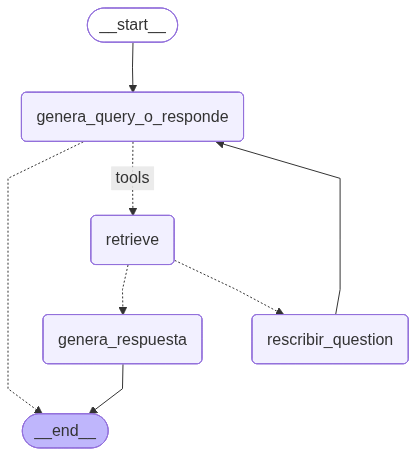

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


### NOtas

In [33]:
from pprint import pprint  # para imprimir bonito

# for chunk in graph.stream(
#     {
#         "messages": [
#             {
#                 "role": "user",
#                 "content": "¿Cómo ha logrado Samsung superar a Google?",
#             }
#         ]
#     }
# ):
#     for node, update in chunk.items():
#         print(f"🔁 Update from node: {node}")
#         print(update["messages"][-1])
#         print("📝 Mensaje generado:")
#         print(messages[-1])
#         print("\n\n")

import pdb
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Dame informacion sobre Honor Magic V5",
            }
        ]
    }
):
    for node, update in chunk.items():
        print(f"📘 Update from node: {node}")
        print("-" * 40)

        messages = update.get("messages", [])
      
        last_msg = messages[-1]

        try:
            if isinstance(last_msg, dict):
                if "content" in last_msg:
                    print("📝 Contenido textual:")
                    print(last_msg["content"])
                elif "tool_calls" in last_msg:
                    print("🔧 Llamada a función:")
                    pprint(last_msg["tool_calls"])
                else:
                    print("🕵️ Mensaje dict sin content/tool_calls:")
                    pprint(last_msg)
            elif hasattr(last_msg, "content"):
                print("📝 Contenido desde objeto:")
                print(last_msg.content)
            else:
                print("🕵️ Mensaje desconocido:")
                pprint(last_msg)

        except Exception as e:
            print("❌ Error leyendo el mensaje:", str(e))
            pprint(last_msg)

        print("-" * 40 + "\n")



📘 Update from node: genera_query_o_responde
----------------------------------------
📝 Contenido desde objeto:

----------------------------------------

score : no
📘 Update from node: retrieve
----------------------------------------
📝 Contenido desde objeto:
TÜV Rheinland Flicker Free

TÜV Rheinland Circadian Friendly

procesador

MediaTek Dimensity 8400 Ultra

GPU Mali-G720

NPU 880

MediaTek Dimensity 9400+

GPU Immortalis-G925 MC12

NPU 890

memoria ram

12 GB LPDDR5x

12 GB LPDDR5x

almacenamiento interno

256, 512 GB UFS 4.1

256, 512 GB, 1 TB UFS 4.1

cámara trasera

Leica VARIO-SUMMILUX 1:1.7-2.2/15-46 ASPH

Angular Light Fusion 800, 50 MP, f/1.7, OIS

Telefoto 50 MP, f/1,9

Gran angular 12 MP, f/2.2, FOV 120º

Vídeo 4K@60 FPS, HDR10+

Leica VARIO-SUMMILUX 1:1.62-3.0/15-115 ASPH

Angular Light Fusion 900, 50 MP, f/1.6, OIS

Telefoto 50 MP, f/3.0, zoom óptico x5

Gran angular 12 MP, f/2.2, FOV 120º

Vídeo 4K@60 FPS, HDR10+

cámara delantera

32MP, f/2.2, FOV 90º

32MP, f/2.2, F

In [34]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "Dame la informacion mas relevanten y resumida sobre Honor Magic V5",
        }
    ]
}

In [35]:
graph.invoke(input)["messages"][-1].pretty_print()

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 8.525614105s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 8
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<loca

score : no
xavi Prompt Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.
Pregunta original:
 ------- 
Dame la informacion mas relevanten y resumida sobre Honor Magic V5
 ------- 
Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:
================================== Ai Message ==================================

Gracias por el análisis detallado y la pregunta reescrita. Entiendo perfectamente la intención de buscar información concisa y relevante sobre el Honor Magic V5, y la importancia de considerar si el modelo existe o si se refiere al plegable más reciente de la serie Honor Magic V.

Agradezco la claridad y precisión de la nueva formulación. Si tienes alguna otra pregunta o quieres que busque información con esta nueva pregunta, házmelo saber.


Notas para la reu: Definición rápida:
Un agente en LangChain es una entidad capaz de razonar paso a paso, decidir qué herramientas o funciones usar, ejecutar acciones (como buscar información, hacer cálculos, llamar APIs, etc.), y combinar resultados para dar una respuesta final.

¿En qué se diferencia de una simple cadena ("chain")?
Chain: Es una secuencia fija de pasos (ej: extrae datos → llama a un LLM → genera texto).

Agente: Toma decisiones sobre qué hacer en cada paso, según el contexto y los resultados anteriores. Puede elegir diferentes herramientas, iterar, preguntar, buscar, etc. No sigue una ruta fija.

¿Cómo funciona un agente en LangChain?
Recibe una pregunta o tarea.

El LLM interpreta la tarea y decide cuál (o cuáles) herramientas necesita para resolverla (por ejemplo: buscar en Google, consultar una base de datos, hacer cálculos, etc.).

Ejecuta acciones: llama a la(s) herramienta(s), analiza los resultados, decide si necesita más pasos.

Itera hasta tener suficiente información.

Redacta la respuesta final al usuario.

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/

